# Titanic Disaster 

The Titanic disaster challenge is one of the most famous datasets.

In this notebook, the following steps are to be performed:
- Exploratory Data Analysis
- Data imputation 
- Feature Engineering 
- base line models and learning curves
- Sequential backward features selection
- Train on new set of features
- Learning ensemble using voting classifier
- Model selection
- generate predictions for test data

### Import all necessary packages

In [1]:
# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.ensemble import  RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Modelling Helpers
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualisations
%matplotlib inline
sns.set_style( 'white' )

f:\Users\Tahar\Anacondanew\envs\ztdl\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Prepare visualizations functions to use for later

In [2]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None ) 
    col = kwargs.get( 'col' , None ) 
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col ) 
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

### Load and have first look at the data

In [3]:
train = pd.read_csv("Documents/titanic/train.csv") #import csv file
test = pd.read_csv("Documents/titanic/test.csv")

In [4]:
describe_more(train)

,Datatype,Levels,Variable
1,int64,2,Survived
4,object,2,Sex
2,int64,3,Pclass
11,object,3,Embarked
6,int64,7,SibSp
7,int64,7,Parch
5,float64,88,Age
10,object,147,Cabin
9,float64,248,Fare
8,object,681,Ticket


In [5]:
describe_more(test)

,Datatype,Levels,Variable
3,object,2,Sex
1,int64,3,Pclass
10,object,3,Embarked
5,int64,7,SibSp
6,int64,8,Parch
9,object,76,Cabin
4,float64,79,Age
8,float64,169,Fare
7,object,363,Ticket
0,int64,418,PassengerId


In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [8]:
test.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Dibden, Mr. William",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Turpin, Mr. William John Robert",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


### from the describe method we notice:
#### Train (891 values) is missing 
177 Age values, 687 Cabin values, and 2 Embarked values
#### Test (418 values) is missing
86 Age values, 1 Fare value, and 327 Cabin values 

#### observation 
Cabin has large proportion of missing values, we may start thinking of discarding it


### Visualization

#### Correlation between DV and IV

From correlation map, we see that Pclass and fare have the highest correlation with survived

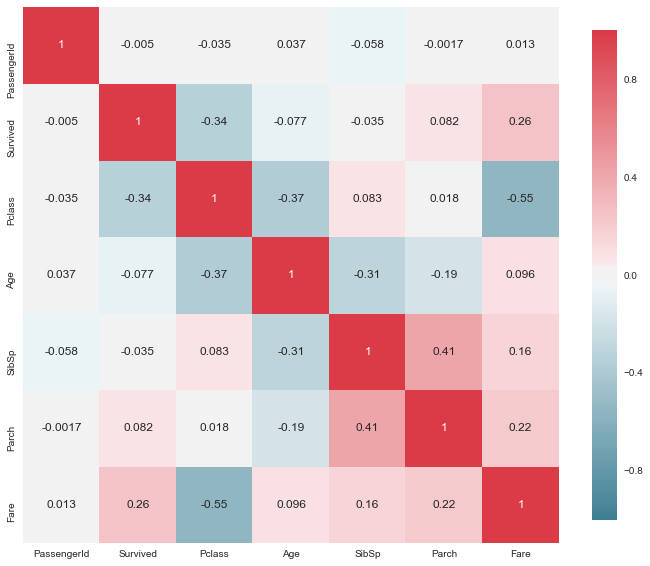

In [12]:
plot_correlation_map(train)

Age and fare are the only continuous variables, and it is useful to know what kind of relationship exists between them

#### Scatter plot: Age & Fare

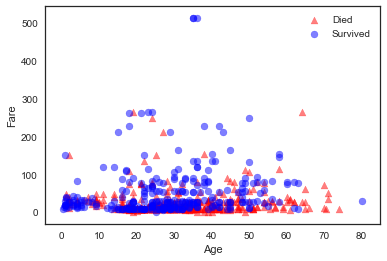

In [13]:
plt.scatter(train['Age'][train['Survived']==0], train['Fare'][train['Survived']==0],
            color='red', marker='^', alpha=0.5, label = 'Died')
plt.scatter(train['Age'][train['Survived']==1], train['Fare'][train['Survived']==1],
            color='blue', marker='o', alpha=0.5, label = 'Survived')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Fare')
plt.show()

The scatter plot doesnt draw a clear picture of the relationship between Age and Fare, this is due to high values present in Fare. one way to overcome this is to raise the variable Fare to the power of (0.35) [Note: this number has been selected after few trials].

we can derive some observations:
- the survival rates for expensive tickes is high
- kids under the age of 10 have high survival rates
- for low price tickets, passengers aged between 20 and 40 show average survival rates, and passengers over 40 yo show low survival rates.

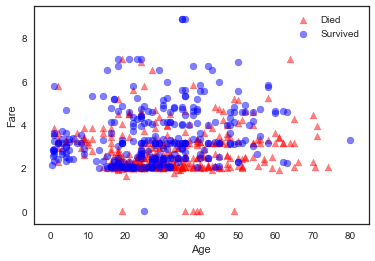

In [14]:
plt.scatter(train['Age'][train['Survived']==0], train['Fare'][train['Survived']==0]**0.35,
            color='red', marker='^', alpha=0.5, label = 'Died')
plt.scatter(train['Age'][train['Survived']==1], train['Fare'][train['Survived']==1]**0.35,
            color='blue', marker='o', alpha=0.5, label = 'Survived')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Fare')
plt.show()

#### Categorical graphs

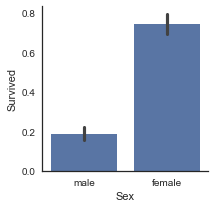

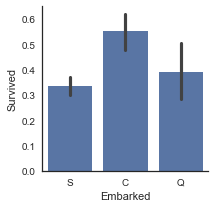

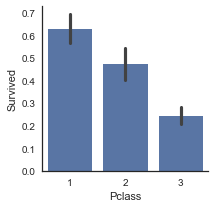

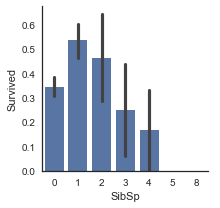

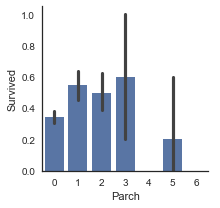

In [15]:
for i in ['Sex','Embarked','Pclass', 'SibSp', 'Parch']:
    plot_categories( train , cat = i , target = 'Survived' )

#### Next we look at Embarked and Pclass

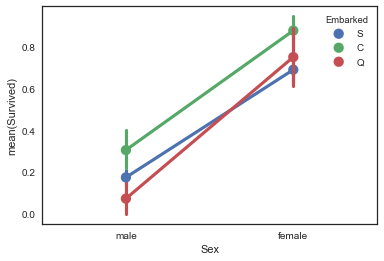

In [16]:
sns.pointplot(x="Sex", y="Survived", hue="Embarked", data=train)

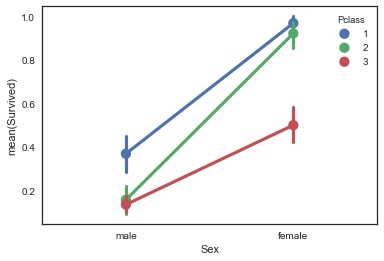

In [17]:
sns.pointplot(x="Sex", y="Survived", hue="Pclass", data=train)

We see that it could be possible to generate a new feature out of the relationship between Pclass and Sex

f:\Users\Tahar\Anacondanew\envs\ztdl\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


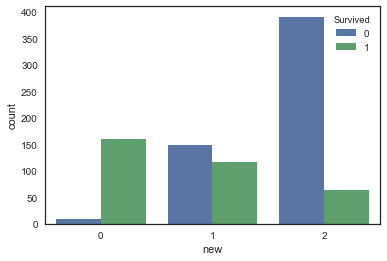

In [18]:
tes = train[["Fare", "Sex", "Survived", "Pclass", "Embarked"]]

def mapp(df):
    if df['Sex'] == 'female':
        if df['Pclass'] == 3:
            return 1
        else:
            return 0
    else:
        if df['Pclass'] == 1:
            return 1
        else:
            return 2
tes['new'] = tes.apply(mapp, axis=1)
sns.countplot(x="new", hue="Survived", data=tes)

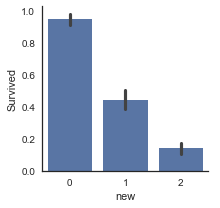

In [19]:
plot_categories( tes , cat = 'new' , target = 'Survived' )

#### Distribution plot : Male & Female

Sex variables looks to be promising. in order to understand better the survival rates of men and women, we first look at proportion of survival for both male and female. The next plot shows clearly that women have more survival rates than men

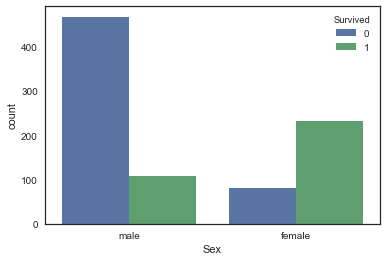

In [20]:
sns.countplot(x="Sex", hue="Survived", data=train)

We move forward and look at the relationship between Sex variable and Age variable, then Sex variable and Fare variable. This can be done by ploting the distribution of Age and Fare then spliting Male and Female on rows on the plot, as shown:

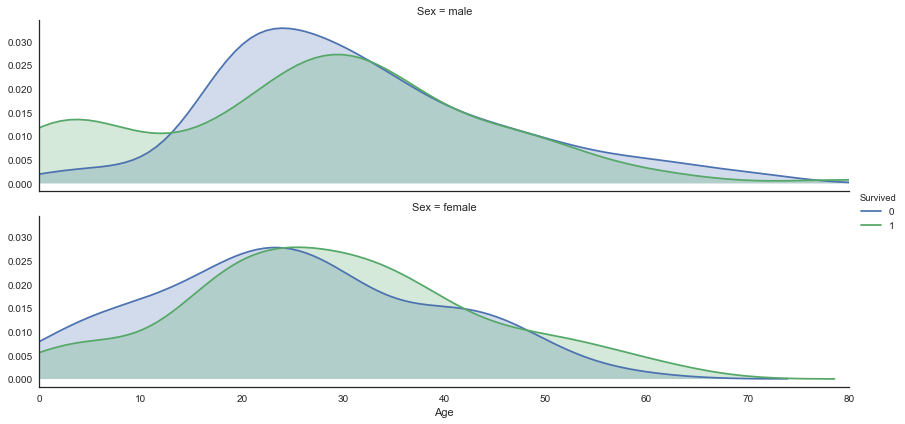

In [21]:
plot_distribution( train , var = 'Age' , target='Survived', row = 'Sex')

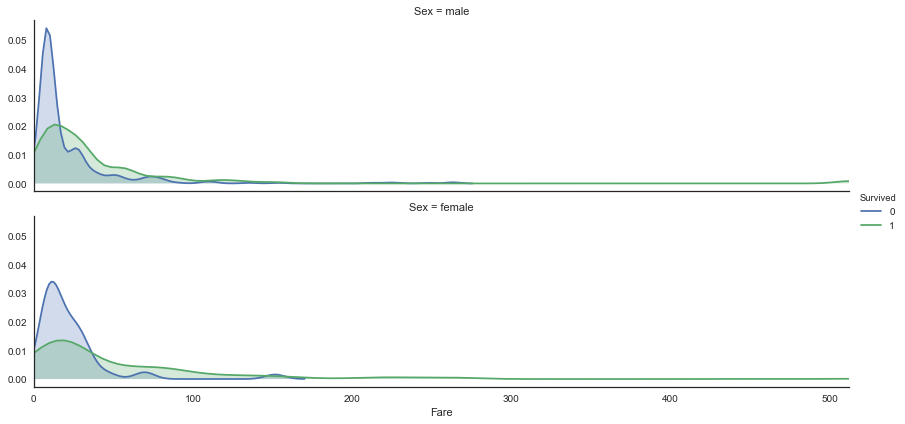

In [22]:
plot_distribution( train , var = 'Fare' , target = 'Survived' , row = 'Sex' )

We can dig deeper and combine each of Age & Fare variables by groups. For now we do an analysis to see what is the best way
to cut the data. I am going to divide each group to contain about 20 percent of the data and see the difference in survival rate between each of the groups. 

in the next steps, I will show the 'manual' or 'hard way' to analysis the data and then give one fast solution

-  First, manual analysis of survival rates between different fare price for both male and female

In [23]:
pd.crosstab(train[(train['Fare']>=0)&(train['Fare']<7.89)]['Sex'], 
            train[(train['Fare']>=0)&(train['Fare']<7.89)]['Survived'], normalize='index')

Survived,0,1
Sex,,
female,0.285714,0.714286
male,0.909091,0.090909


In [24]:
fare_custom = pd.crosstab(train[(train['Fare']>=7.89)&(train['Fare']<11)]['Sex'], 
            train[(train['Fare']>=7.89)&(train['Fare']<11)]['Survived'])

In [25]:
print("for Fare  7.89, Died and Survived: ", sum(fare_custom[0]),",", sum(fare_custom[1]))

for Fare  7.89, Died and Survived:  146 , 33


- g5: >=40
- g4: >=22
- g3: >=11
- g2: >=7.89
- g1: <7.89

In [26]:
sum(fare_custom[0])+sum(fare_custom[1]), (sum(fare_custom[0])+sum(fare_custom[1]))*100/len(train)

(179, 20.089786756453424)

By the end of the process, the choice of 20% of data cut was good and it may be used in featuring engineering later on. Next, I will construct two dataframes for rates of survival for both male and female using the 20% cut and then visualize the result

In [27]:
lis = [0,7.89,11,22,40]
female_grouping = pd.DataFrame()
male_grouping = pd.DataFrame()
all_grouping = pd.DataFrame()

for i,j in enumerate(lis):
    try:
        tab = pd.crosstab(train[(train['Fare']>=lis[i])&(train['Fare']<lis[i+1])]['Sex'], 
                          train[(train['Fare']>=lis[i])&(train['Fare']<lis[i+1])]['Survived'])
        female_grouping = pd.concat([female_grouping, tab.loc['female']], axis=1)
        male_grouping = pd.concat([male_grouping, tab.loc['male']], axis=1)
        all_grouping = pd.concat([male_grouping, tab], axis=1)
    except:
        tab = pd.crosstab(train[(train['Fare']>=lis[i])]['Sex'], 
                          train[(train['Fare']>=lis[i])]['Survived'])
        female_grouping = pd.concat([female_grouping, tab.loc['female']], axis=1)
        male_grouping = pd.concat([male_grouping, tab.loc['male']], axis=1)
female_grouping.columns = ['g1','g2','g3','g4', 'g5']
female_grouping = female_grouping.reset_index()
male_grouping.columns = ['g1','g2','g3','g4', 'g5']
male_grouping = male_grouping.reset_index()

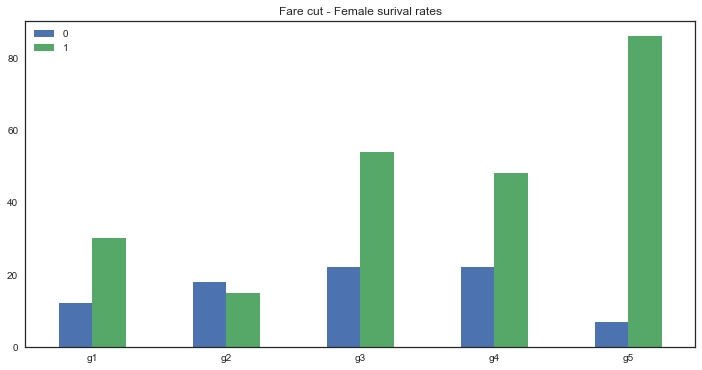

In [28]:
fg_t = female_grouping[female_grouping.columns[1:]].T
fg_t.plot(kind='bar', figsize=(12,6), rot=0, title= 'Fare cut - Female surival rates')

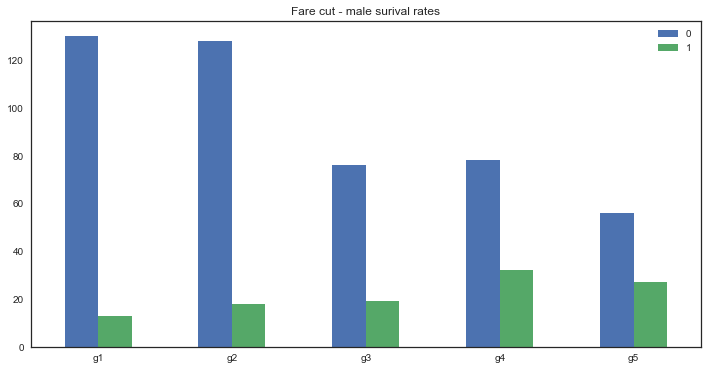

In [29]:
mg_t = male_grouping[male_grouping.columns[1:]].T
mg_t.plot(kind='bar', figsize=(12,6), rot=0, title= 'Fare cut - male surival rates')

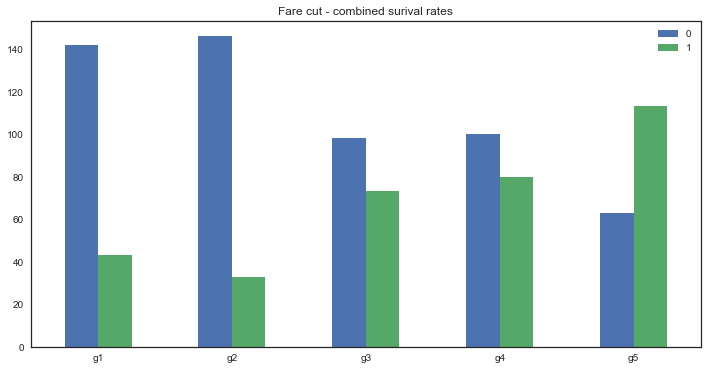

In [30]:
(mg_t+fg_t).plot(kind='bar', figsize=(12,6), rot=0, title= 'Fare cut - combined surival rates')

-  one straightfoward way to make perform the same operation is to use "pd.qcut" method

In [31]:
fare_qcut, bins = pd.qcut(train['Fare'], 5, labels=['g1','g2','g3','g4','g5'], retbins=True)
qcut_df = pd.DataFrame(fare_qcut)
qcut_df['Survived'] = train['Survived']

The result is similar to the work performed above and this is shown in the graph bellow

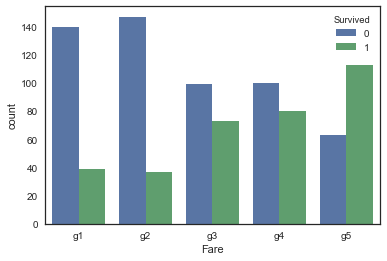

In [32]:
sns.countplot(x="Fare", hue="Survived", data=qcut_df)

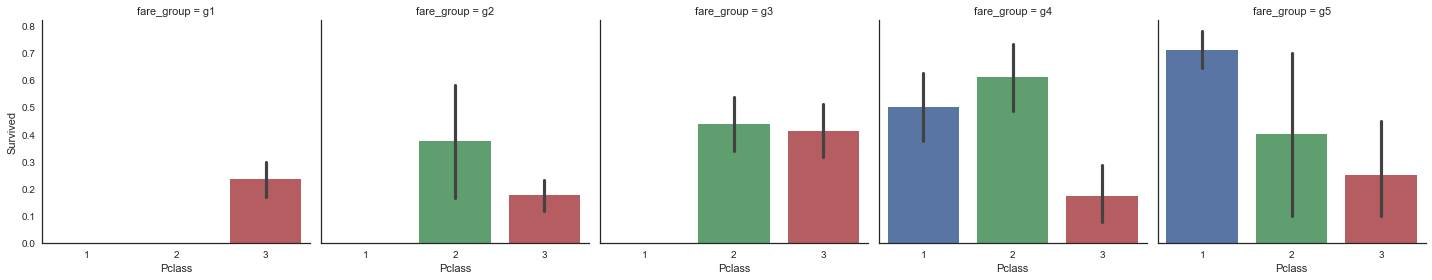

In [33]:
train["fare_group"] = qcut_df['Fare']
sns.factorplot(x="Pclass", y="Survived",
              col="fare_group", data=train, kind="bar")

I am curious about those passengers who are from 3rd class and still have expensive tickets, I am going to investigate the matter

In [34]:
extract_name= []
extract_name = train["Name"][(train["fare_group"]=='g5')&(train['Pclass']==3)].map( lambda name: name.split( ',' )[0])
name_dict = {}
for i in extract_name:
    if i in name_dict:
        name_dict[i] = name_dict[i]+1
    else:
        name_dict[i] = 1
name_dict

{'Bing': 1,
 'Chip': 1,
 'Foo': 1,
 'Goodwin': 6,
 'Lam': 2,
 'Lang': 1,
 'Ling': 1,
 'Sage': 7}

In [35]:
import re 

p = re.compile(r'^Goodwin')
idx = []
def regg(x):
    if p.search(x.loc["Name"]):
        idx.append(train[train["Name"]==x["Name"]].index.values[0])
train.apply(regg, axis=1)
train.iloc[idx]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,fare_group
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9,NaN,S,g5
71,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9,NaN,S,g5
386,387,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9,NaN,S,g5
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9,NaN,S,g5
678,679,0,3,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43.0,1,6,CA 2144,46.9,NaN,S,g5
683,684,0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.9,NaN,S,g5


from website(http://www.icyousee.org/titanic.html), in the section Tickets, I quote "First Class tickets ranged from £30 for a berth to £870 for a luxury suite with a private fifty-foot promenade and the only private lavatory and toilet facilities in all the ship. A Second Class ticket could be purchased for as little as £12"

from this, I assume that all 3rd class with more than one person in the family and have a fare equal or over 12, they need to be assigned  a new fare value as follows

In [36]:
train[ 'FamilySize' ] = train[ 'Parch' ] + train[ 'SibSp' ]+ 1
test[ 'FamilySize' ] = test[ 'Parch' ] + test[ 'SibSp' ]+ 1

In [37]:
def newfare(x):
    famsize, pclass, fare = x
    if famsize >1 and pclass==3 and fare>=12:
        return fare/famsize
    else:
        return fare
train.drop("fare_group",axis=1, inplace=True)
train['new_fare'] = train[["FamilySize","Pclass","Fare"]].apply(newfare, axis=1)
test['new_fare'] = test[["FamilySize","Pclass","Fare"]].apply(newfare, axis=1)

In [38]:
train_fare_qcut, bins = pd.qcut(train['new_fare'], 5, labels=['g1','g2','g3','g4','g5'], retbins=True)
train_fare_qcut_df = pd.DataFrame(train_fare_qcut)
test_fare_qcut, bins = pd.qcut(test['new_fare'], 5, labels=['g1','g2','g3','g4','g5'], retbins=True)
test_fare_qcut_df = pd.DataFrame(test_fare_qcut)
train["fare_group"] = train_fare_qcut_df["new_fare"]
test["fare_group"] = test_fare_qcut_df["new_fare"]

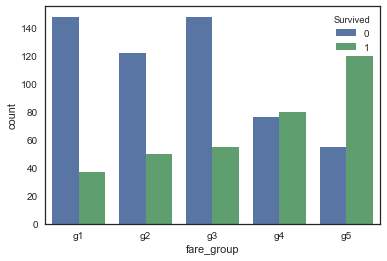

In [39]:
sns.countplot(x="fare_group", hue="Survived", data=train)

so far we looked only at Fare, Sex, Pclass and Embarked. we are missing Age and Cabin and this is because there are many missing values, we will start by impute those missing values then we rework the Parch and SibSp variables. Finally, we will analyse them and see if we can extract new features

### Dealing with missing values

In [40]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,new_fare,fare_group
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1,NaN,NaN


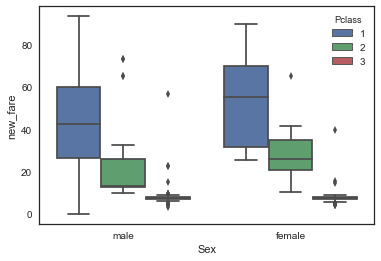

In [41]:
sns.boxplot(x="Sex", y="new_fare", hue='Pclass', data=test[test["Fare"]<100])

In [42]:
def fill_missing_fare(df):
    median_fare=df[(df['Pclass'] == 3) & (df['Embarked'] == 'S')]['new_fare'].median()
#'S'
       #print(median_fare)
    df["new_fare"] = df["new_fare"].fillna(median_fare)
    return df
test=fill_missing_fare(test)

In [43]:
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,new_fare,fare_group
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1,80.0,g5
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1,80.0,g5


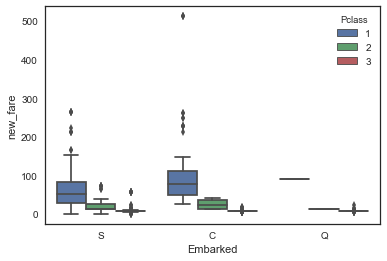

In [44]:
sns.boxplot(x="Embarked", y="new_fare", hue="Pclass", data=train)

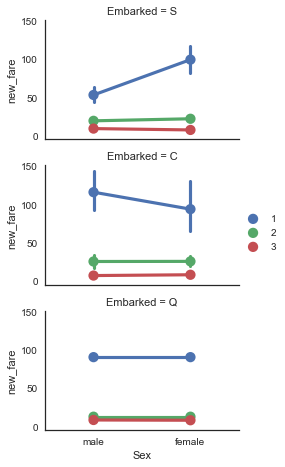

In [45]:
grid = sns.FacetGrid(train, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Sex','new_fare', 'Pclass', palette='deep')
grid.add_legend()

In [46]:
train["Embarked"] = train["Embarked"].fillna('C')

In [47]:
train.describe(), test.describe()

(       PassengerId    Survived      Pclass         Age       SibSp  \
 count   891.000000  891.000000  891.000000  714.000000  891.000000   
 mean    446.000000    0.383838    2.308642   29.699118    0.523008   
 std     257.353842    0.486592    0.836071   14.526497    1.102743   
 min       1.000000    0.000000    1.000000    0.420000    0.000000   
 25%     223.500000    0.000000    2.000000   20.125000    0.000000   
 50%     446.000000    0.000000    3.000000   28.000000    0.000000   
 75%     668.500000    1.000000    3.000000   38.000000    1.000000   
 max     891.000000    1.000000    3.000000   80.000000    8.000000   
 
             Parch        Fare  FamilySize    new_fare  
 count  891.000000  891.000000  891.000000  891.000000  
 mean     0.381594   32.204208    1.904602   29.306084  
 std      0.806057   49.693429    1.613459   50.287165  
 min      0.000000    0.000000    1.000000    0.000000  
 25%      0.000000    7.910400    1.000000    7.750000  
 50%      0.00000

In [48]:
train.describe(include=['O']), test.describe(include=['O'])

(                                   Name   Sex    Ticket    Cabin Embarked
 count                               891   891       891      204      891
 unique                              891     2       681      147        3
 top     Turpin, Mr. William John Robert  male  CA. 2343  B96 B98        S
 freq                                  1   577         7        4      644,
                        Name   Sex    Ticket            Cabin Embarked
 count                   418   418       418               91      418
 unique                  418     2       363               76        3
 top     Dibden, Mr. William  male  PC 17608  B57 B59 B63 B66        S
 freq                      1   266         5                3      270)

from the describe, we observe that Age and cabin are the only missing values in both sets. we are going to apply predictive imputation. We will start by combining both sets in one set.

In [49]:
full = train.append(test, ignore_index=True)

In [50]:
print('number of missing Age in train dataset', train['Age'].isnull().sum())
print('number of missing Age in test dataset', test['Age'].isnull().sum())
print('number of missing Age in full dataset', full['Age'].isnull().sum())

number of missing Age in train dataset 177
number of missing Age in test dataset 86
number of missing Age in full dataset 263


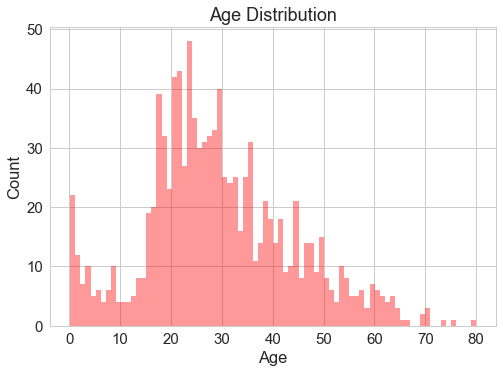

In [51]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(full["Age"].dropna(),
                 bins=80,
                 kde=False,
                 color="red")
    sns.plt.title("Age Distribution")
    plt.ylabel("Count")

For age prediction we are going to use a Randomforestregressor. but first we need to map Sex values as follows: male:0, female:1, and baby:2 (we consider babies as genderless)

In [52]:
def age_sex(passenger):
    age, sex = passenger
    if age <1:
        return 'baby'
    else:
        return sex
full['Sex'] = full[['Age','Sex']].apply(age_sex,axis=1)
Sex_mapping = {'male':0, 'female':1, 'baby':3}
full['Sex'] = full['Sex'].map(Sex_mapping)

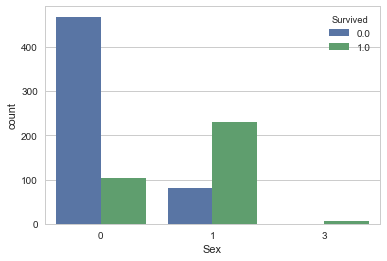

In [53]:
sns.countplot(x="Sex", hue="Survived", data=full)

In [54]:
from sklearn.ensemble import RandomForestRegressor
#predicting missing values in age using Random Forest
def fill_missing_age(df):
    
    #Feature set
    age_df = df[['Age','new_fare', 'Parch', 'SibSp',
                 'Pclass', 'Sex']]
    # Split sets into train and test
    train  = age_df.loc[ (df.Age.notnull()) ]# known Age values
    test = age_df.loc[ (df.Age.isnull()) ]# null Ages
    
    # All age values are stored in a target array
    y = train.values[:, 0]
    
    # All the other values are stored in the feature array
    X = train.values[:, 1::]
    
    # Create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedAges = rtr.predict(test.values[:, 1::])
    
    # Assign those predictions to the full data set
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
    return df

In [55]:
full =fill_missing_age(full)

The new distribution of age

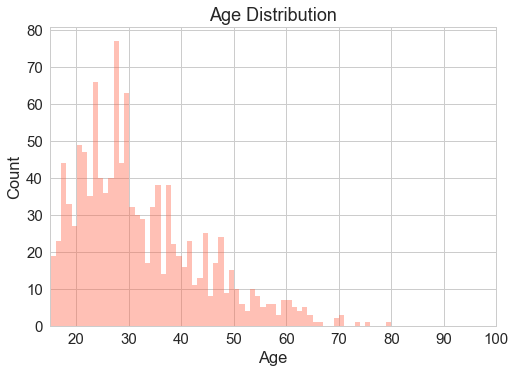

In [56]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(full["Age"].dropna(),
                 bins=80,
                 kde=False,
                 color="tomato")
    sns.plt.title("Age Distribution")
    plt.ylabel("Count")
    plt.xlim((15,100));

Next we impute for Cabin.

In [57]:
full.Cabin.describe()

count             295
unique            186
top       C23 C25 C27
freq                6
Name: Cabin, dtype: object

in this imputation we want to have cabin listed from A to T, and X is assigned to null values

In [58]:
full[ 'Cabin' ] = full[ 'Cabin' ].fillna( 'X' )
full['Cabin'] = full['Cabin'].map( lambda c : c[0] )

In [59]:
full.Cabin.value_counts()

X    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

In [60]:
print('number of missing cabin in train dataset', train['Cabin'].isnull().sum())
print('number of missing cabin in test dataset', test['Cabin'].isnull().sum())
print('number of missing cabin in full dataset', full['Cabin'].isnull().sum())

number of missing cabin in train dataset 687
number of missing cabin in test dataset 327
number of missing cabin in full dataset 0


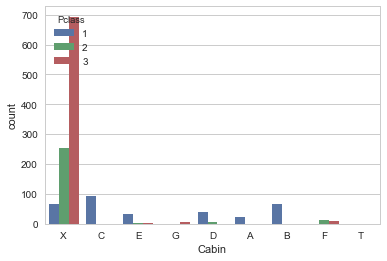

In [61]:
sns.countplot(x="Cabin", hue="Pclass", data=full)

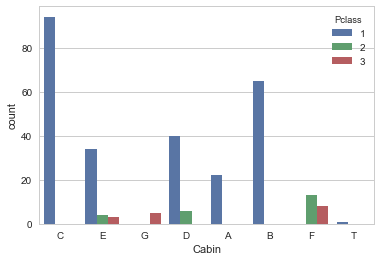

In [62]:
sns.countplot(x="Cabin", hue="Pclass", data=full[full['Cabin']!='X'])

we can see that class 1 is having exclusively cabins: A,B,C,T, then there is D shared with Class 2, and E shared with class2 and 3. class 3 is exclusively present in G and sharing E and F with class 2


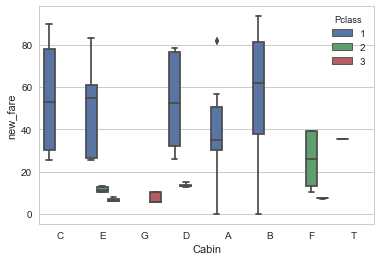

In [63]:
sns.boxplot(x="Cabin", y="new_fare", hue='Pclass', data=full[(full['Cabin']!='X')&(full['new_fare']<100)])

In [64]:
#another way to assign unknown cabins is to assign by fare quantiles 
#cabin['Cabin'] = np.where((cabin.Cabin =='X') & (cabin.Pclass == 1) ,'E',cabin.Cabin)
#cabin['Cabin'] = np.where((cabin.Cabin =='E') & (cabin.Pclass == 1) & (cabin.Fare >= 52.0 ) ,'C',cabin.Cabin)
#cabin['Cabin'] = np.where((cabin.Cabin =='C') & (cabin.Pclass == 1) & (cabin.Fare >= 84.383350 ) ,'B',cabin.Cabin)

In [65]:
full[['Cabin','Age','Sex','new_fare','Parch','Pclass','SibSp']].head()

,Cabin,Age,Sex,new_fare,Parch,Pclass,SibSp
0,X,22.0,0,7.2500,0,3,1
1,C,38.0,1,71.2833,0,1,1
2,X,26.0,1,7.9250,0,3,0
3,C,35.0,1,53.1000,0,1,1
4,X,35.0,0,8.0500,0,3,0


In [66]:
def fill_missing_cabin(df):
    
    #Feature set
    cabin_df = df[['Cabin','Age','Sex','new_fare','Parch','Pclass','SibSp']]

    # Split sets into train and test
    train_new  = cabin_df.loc[ (df.Cabin !='X') ]# known cabin
    test_new = cabin_df.loc[ (df.Cabin == 'X') ]# X cabin

    # All age values are stored in a target array
    y = train_new.values[:, 0]
    
    # All the other values are stored in the feature array
    X = train_new.values[:, 1::]
    
    # Create and fit a model
    rtr = RandomForestClassifier(n_estimators=100, max_features='sqrt', n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedCabin = rtr.predict(test_new.values[:, 1::])
    
    # Assign those predictions to the full data set
    df.loc[ (df.Cabin =='X'), 'Cabin' ] = predictedCabin
    
    return df

In [67]:
full= fill_missing_cabin(full)

In [68]:
full.describe(include=['O'])

,Cabin,Embarked,Name,Ticket
count,1309,1309,1309,1309
unique,8,3,1307,929
top,F,S,"Connolly, Miss. Kate",CA. 2343
freq,687,914,2,11


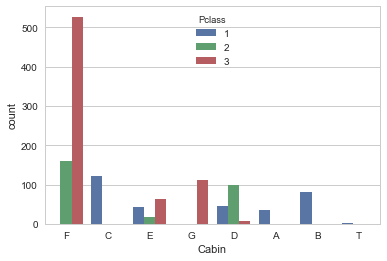

In [69]:
sns.countplot(x="Cabin", hue="Pclass", data=full)

In [70]:
print ('Datasets', 'Full:', full.shape, 'train', train.shape, 'test', test.shape, )

Datasets Full: (1309, 15) train (891, 15) test (418, 14)


In [71]:
full.head()

,Age,Cabin,Embarked,FamilySize,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,fare_group,new_fare
0,22.0,F,S,2,7.2500,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,g1,7.2500
1,38.0,C,C,2,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,g5,71.2833
2,26.0,F,S,1,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,g2,7.9250
3,35.0,C,S,2,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,g5,53.1000
4,35.0,F,S,1,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,g3,8.0500


## Features engineering

**Note:** *when creating dummy variables, it is possible to fully represent a feature that has k class with k-1 dummy variables*

In [72]:
embarked = pd.get_dummies(full.Embarked, prefix="Embarked")
embarked.drop('Embarked_S',axis=1,inplace=True)
embarked.head()

,Embarked_C,Embarked_Q
0,0,0
1,1,0
2,0,0
3,0,0
4,0,0


In [73]:
pclass = pd.get_dummies( full.Pclass , prefix='Pclass' )
pclass.drop('Pclass_3', axis=1,inplace=True)
pclass.head()

,Pclass_1,Pclass_2
0,0,0
1,1,0
2,0,0
3,1,0
4,0,0


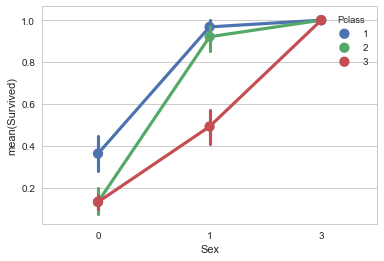

In [74]:
sns.pointplot(x="Sex", y="Survived", hue="Pclass", data=full)

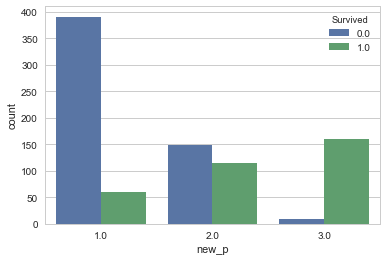

In [75]:
def mapp(df):
    if df['Sex'] == 1:
        if df['Pclass'] == 3:
            return 2
        else:
            return 3
    elif df['Sex'] == 0:
        if df['Pclass'] == 1:
            return 2
        else:
            return 1
full['new_p'] = full.apply(mapp, axis=1)
sns.countplot(x="new_p", hue="Survived", data=full)

In [76]:
new_p = pd.get_dummies(full.new_p, prefix = "newp")
new_p.drop('newp_3.0',axis=1,inplace=True)
new_p.head()

,newp_1.0,newp_2.0
0,1,0
1,0,0
2,0,1
3,0,0
4,1,0


In [77]:
cabin = pd.get_dummies(full.Cabin, prefix='Cabin')
cabin.drop('Cabin_T',axis=1,inplace=True)
cabin.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G
0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0


In [78]:
fare_group = pd.get_dummies(full.fare_group, prefix='Fare')
fare_group.drop('Fare_g5',axis=1,inplace=True)
fare_group.head()

,Fare_g1,Fare_g2,Fare_g3,Fare_g4
0,1,0,0,0
1,0,0,0,0
2,0,1,0,0
3,0,0,0,0
4,0,0,1,0


In [79]:
title = pd.DataFrame()
# we extract the title from each name
title[ 'Title' ] = full[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )
sorted(title.Title.unique())

['Capt',
 'Col',
 'Don',
 'Dona',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir',
 'the Countess']

In [80]:
# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Rare",
                    "Col":        "Rare",
                    "Don":        "Rare",
                    "Dona":       "Rare",
                    "Dr":         "Rare",
                    "Jonkheer":   "Rare",
                    "Lady" :      "Rare",
                    "Major":      "Rare",
                    "Master" :    "Master",
                    "Miss" :      "Miss",
                    "Mlle":       "Miss",
                    "Mme":        "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Ms":         "Miss",
                    "Rev":        "Rare",
                    "Sir" :       "Rare",
                    "the Countess":"Rare"             
                    }

# we map each title
title[ 'Title' ] = title.Title.map( Title_Dictionary )
title = pd.get_dummies( title.Title )
#title = pd.concat( [ title , titles_dummies ] , axis = 1 )
title.drop('Rare',axis=1,inplace=True)
title.head()

,Master,Miss,Mr,Mrs
0,0,0,1,0
1,0,0,0,1
2,0,1,0,0
3,0,0,0,1
4,0,0,1,0


In [81]:
full[ 'Title' ] = full[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )
full[ 'Title' ] = full.Title.map( Title_Dictionary )

In [82]:
# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket( ticket ):
    ticket = ticket.replace( '.' , '' )
    ticket = ticket.replace( '/' , '' )
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

# Extracting dummy variables from tickets:
ticket[ 'Ticket' ] = full[ 'Ticket' ].map( cleanTicket )
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )

ticket.head()

,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [83]:
full['Ticket_Len'] = full['Ticket'].apply(lambda x: len(x))
ticketlen = full['Ticket_Len']

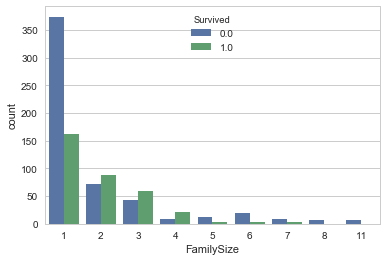

In [84]:
sns.countplot(x="FamilySize", hue="Survived", data=full)

In [85]:
family = pd.DataFrame()

# introducing a new feature : the size of families (including the passenger)
#family[ 'FamilySize' ] = full[ 'Parch' ] + full[ 'SibSp' ] + 1

# introducing other features based on the family size
family[ 'Family_Single' ] = full[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
family[ 'Family_Small' ]  = full[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
family[ 'Family_Large' ]  = full[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )
family.drop('Family_Large',axis=1,inplace=True)
family.head()

,Family_Single,Family_Small
0,0,1
1,0,1
2,1,0
3,0,1
4,1,0


[0 1 2 3]


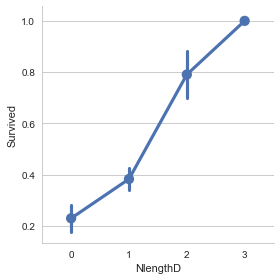

In [86]:
#Create feture for length of name 
# The .apply method generates a new series
name = pd.DataFrame(full[['Name','Survived']])
name['NameLength'] = name["Name"].apply(lambda x: len(x))
bins = [0, 20, 40, 57, 85]
group_names = ['short', 'okay', 'good', 'long']
name['NlengthD'] = pd.cut(name['NameLength'], bins, labels=group_names)
#name['NlengthD']= labelEnc.fit_transform(name['NlengthD'].values)
LengthID_mapping = {'short':0,'okay':1, 'good':2, 'long':3}
name['NlengthD'] = name['NlengthD'].map(LengthID_mapping)
full['namelength'] = name['NlengthD']
sns.factorplot(x="NlengthD", y="Survived", data= name[:len(train)])
print(name[len(train):]["NlengthD"].unique())

In [87]:
name = pd.get_dummies(name['NlengthD'], prefix= 'namelength')
name.drop('namelength_3',axis=1,inplace=True)
name.head()

,namelength_0,namelength_1,namelength_2
0,0,1,0
1,0,0,1
2,0,1,0
3,0,0,1
4,0,1,0


In [88]:
adult = pd.DataFrame()
adult['adult'] = full[ 'Age'].map( lambda s : 1 if 18 <= s else 0 )
full['adult'] = adult['adult'] 
adult.head()

,adult
0,1
1,1
2,1
3,1
4,1


I am curious if it is worthy to divide Age to groups lik fare. so I do a cut on 5 groups, then visualize the result while comparing it with Adult feature

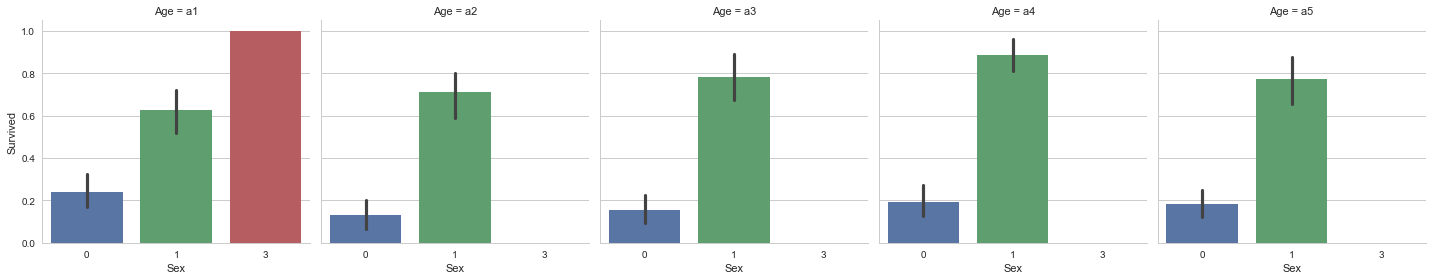

In [89]:
age_qcut, bins = pd.qcut(full['Age'], 5, labels=['a1','a2','a3','a4','a5'], retbins=True)
age_qcut_df = pd.DataFrame(age_qcut)
age_qcut_df['Survived'] = full['Survived']
age_qcut_df['Pclass'] = full['Pclass']
age_qcut_df['Sex'] = full['Sex']
sns.factorplot(x="Sex", y="Survived",
              col="Age", data=age_qcut_df, kind="bar")

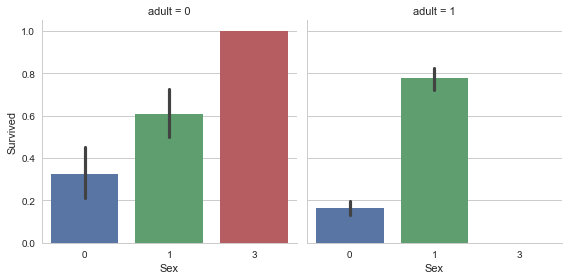

In [90]:
sns.factorplot(x="Sex", y="Survived",
              col="adult", data=full, kind="bar")

it is very clear that there is no need to do the cut, and we just need the adult feature instead of Age

In [91]:
# create a feature mother. maybe women with babies have higher survival rates than single women
mother = pd.DataFrame ()
mother['mother'] =  np.where((full.Sex ==1) & (full.Age > 18) & (full.Title !='Miss') & (full.Parch>0),1,0)
full['mother'] =  np.where((full.Sex ==1) & (full.Age > 18) & (full.Title !='Miss') & (full.Parch>0),1,0)
mother.head()

,mother
0,0
1,0
2,0
3,0
4,0


In [92]:
pd.crosstab(full["Survived"][full['Sex']==1],full["mother"], normalize="columns")

mother,0,1
Survived,,
0.0,0.251938,0.296296
1.0,0.748062,0.703704


The feature mother doesn't behave as expected and may not be that worthy in the model

In [93]:
parsib = full[['SibSp','Parch']]

In [94]:
sex = full["Sex"]

# Data pre-processing

In [101]:
# Select all features 
full_X = pd.concat( [pclass, new_p, mother, cabin, sex, adult, fare_group, parsib, title,embarked,family,full.Survived], axis=1 ) 


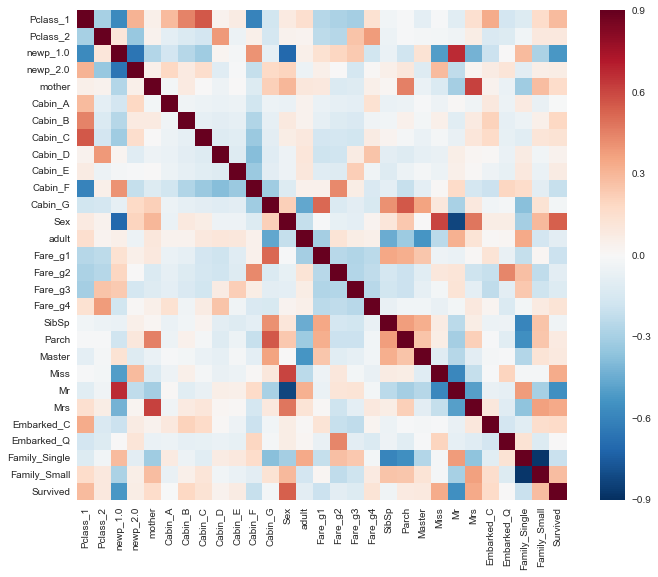

In [102]:
# use correlation heatmap to exclude features that are highly correlated with each other
corrmat = full_X.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [164]:
# take a subset of features 
full_X = pd.concat( [adult, fare_group, parsib, title, embarked, new_p], axis=1 ) 

In [165]:
# Select X,y, and submission variables as numpy array
X = full_X[ 0:len(train) ].values
y = train.Survived
test_submission = full_X[len(train):].values
full_X.shape, train.shape, test.shape, full.shape

((1309, 15), (891, 15), (418, 14), (1309, 21))

In [166]:
X.shape, y.shape

((891, 15), (891,))

In [167]:
# my data ranges from 0 to 1, if you have different scales, you may consider to rescale the data

#from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, scale

#stdsc = MinMaxScaler()
#X_std = scale(X)
#test_submission_std = scale(test_submission)
#X_std = stdsc.fit_transform(X)
#test_submission_std = stdsc.fit_transform(test_submission)


The cross-validation model that is used here is : split the data into Train and Test, then use kfold cross-validation on Train data, then finally use the Test data

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Since there is a class imbalance, stratify ensures that the ratio is kept when splitting the data

In [169]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((623, 15), (268, 15), (623,), (268,))

In [170]:
# due to the imbalance of the classes in target variable, a StratifiedKfold crossvalidation is going to be used
kfold = StratifiedKFold(n_splits=3)

In [171]:
# Select few algorithms to test
random_state = 22
classifiers = [] # combine all alogorithms in a list
classifiers.append(SVC(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))

                   

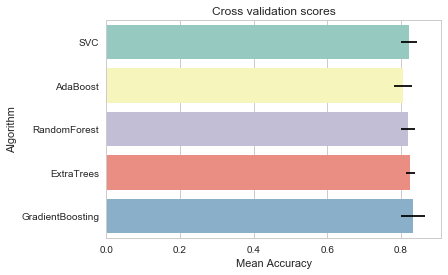

In [172]:
cv_results = [] 
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1))

cv_means = []
cv_std   = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_df = pd.DataFrame({'CrossValMeans':cv_means,'CrossValerrors':cv_std,
                      "Algorithm":['SVC','AdaBoost','RandomForest','ExtraTrees','GradientBoosting']})
# Make a bar graph of cross validation results
f = sns.barplot('CrossValMeans','Algorithm',data=cv_df,palette='Set3',orient='h', **{'xerr':cv_std})
f.set_xlabel("Mean Accuracy")
f.set_title('Cross validation scores')
    
    



In [173]:
# This is a function to calculate confidence interval, check Sebastian Raschka blog for reference https://sebastianraschka.com/blog/2016/model-evaluation-selection-part1.html
n = len(y_test)
z = 1.96
def conf_inter(ACC,n,z):
    print ("the condifedence interval is ({},{})".format(ACC-z*((1/n)*ACC*(1-ACC))**0.5,ACC+z*((1/n)*ACC*(1-ACC))**0.5))

In [174]:
# Hyper parameters tunning

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_

print('Cross validation score: {}\nTest score: {}'.format(gsadaDTC.best_score_,ada_best.score(X_test,y_test)))

Fitting 3 folds for each of 112 candidates, totalling 336 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    5.9s


Cross validation score: 0.8154093097913323
Test score: 0.8022388059701493


[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    7.1s finished


In [175]:
ACC = ada_best.score(X_test,y_test)

conf_inter(ACC,n,z)

the condifedence interval is (0.7545505933584239,0.8499270185818747)


In [176]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
print('Cross validation score: {}\nTest score: {}'.format(gsExtC.best_score_,ExtC_best.score(X_test,y_test)))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   14.0s finished


Cross validation score: 0.8298555377207063
Test score: 0.8246268656716418


In [177]:
ACC = ExtC_best.score(X_test,y_test)

In [178]:
conf_inter(ACC,n,z)

the condifedence interval is (0.7790967298224174,0.8701570015208662)


In [179]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {'max_depth' : [5,6,7,8],
              "max_features": [3, 5, 'sqrt'],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[300],
              "criterion": ["gini",'entropy']}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
print('Cross validation score: {}\nTest score: {}'.format(gsRFC.best_score_,RFC_best.score(X_test,y_test)))

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  6.7min finished


Cross validation score: 0.8378812199036918
Test score: 0.8171641791044776


In [180]:
ACC = RFC_best.score(X_test,y_test)
conf_inter(ACC,n,z)

the condifedence interval is (0.770886243465935,0.8634421147430201)


In [181]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [1,0.1, 0.05, 0.01],
              'max_depth': [4, 5,8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1,None] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
print('Cross validation score: {}\nTest score: {}'.format(gsGBC.best_score_,GBC_best.score(X_test,y_test)))

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   40.4s
[Parallel(n_jobs=4)]: Done 648 out of 648 | elapsed:   58.8s finished


Cross validation score: 0.8218298555377207
Test score: 0.7985074626865671


In [182]:
ACC = GBC_best.score(X_test,y_test)
conf_inter(ACC,n,z)

the condifedence interval is (0.75048353826179,0.8465313871113442)


In [183]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf','linear'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsSVMC.fit(X_train,y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_
print('Cross validation score: {}\nTest score: {}'.format(gsSVMC.best_score_,SVMC_best.score(X_test,y_test)))

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:  1.3min finished


Cross validation score: 0.8394863563402889
Test score: 0.835820895522388


In [184]:
ACC = SVMC_best.score(X_test,y_test)
conf_inter(ACC,n,z)

the condifedence interval is (0.7914698126777817,0.8801719783669943)


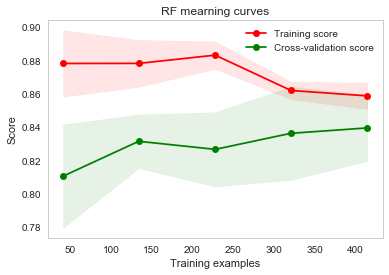

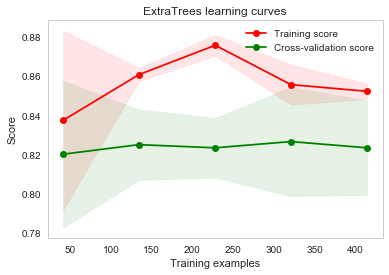

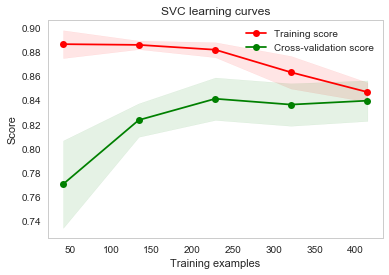

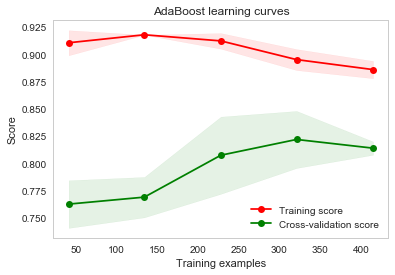

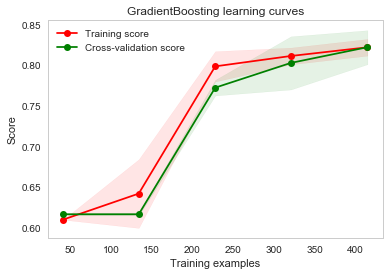

In [185]:
# Plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,y_train,cv=kfold)

In [186]:
# This is an implementation of the Sequential Backward Selection (SBS) (Reference: Python Machine learning - Sebastian Raschka p118)

from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
class SBS():
    def __init__(self, estimator, k_features, 
        scoring=accuracy_score,
        test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=self.test_size, 
                                 random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    def transform(self, X):
        return X[:, self.indices_]    
    def _calc_score(self, X_train, y_train, 
                          X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [ ]:
sbs = SBS(gsSVMC, k_features=5)
sbs.fit(X_train, y_train)

In [190]:
max(sbs.scores_)

0.82692307692307687

In [194]:
inx = list(sbs.scores_).index(max(sbs.scores_))

In [195]:
col = full_X.columns[list(sbs.subsets_[inx])].tolist()

In [196]:
# select new set of features
full_X = full_X[col]

In [197]:
test_submission = full_X[len(train):].values

In [198]:
full_X.head()

,adult,Fare_g1,Fare_g2,Fare_g3,Fare_g4,Parch,Master,Miss,Mrs,Embarked_C,Embarked_Q,newp_1.0,newp_2.0
0,1,1,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,1,1,0,0,0
2,1,0,1,0,0,0,0,1,0,0,0,0,1
3,1,0,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,0,1,0


In [199]:
X = full_X[ 0:len(train) ].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Since there is a class imbalance, stratify ensures that the ratio is kept when splitting the data

In [200]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 13), (179, 13), (712,), (179,))

In [202]:
kfold = StratifiedKFold(n_splits = 3)

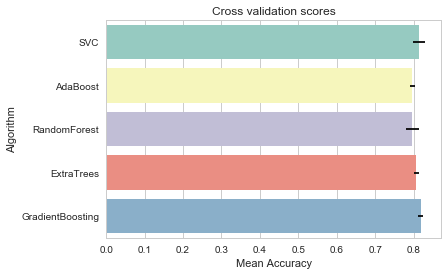

In [203]:
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1))

cv_means = []
cv_std   = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_df = pd.DataFrame({'CrossValMeans':cv_means,'CrossValerrors':cv_std,
                      "Algorithm":['SVC','AdaBoost','RandomForest','ExtraTrees','GradientBoosting']})
f = sns.barplot('CrossValMeans','Algorithm',data=cv_df,palette='Set3',orient='h', **{'xerr':cv_std})
f.set_xlabel("Mean Accuracy")
f.set_title('Cross validation scores')
    
    



In [204]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_

print('Cross validation score: {}\nTest score: {}'.format(gsadaDTC.best_score_,ada_best.score(X_test,y_test)))

Fitting 3 folds for each of 112 candidates, totalling 336 fits


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:    5.3s


Cross validation score: 0.8061797752808989
Test score: 0.7988826815642458


[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    6.5s finished


In [205]:
ACC = ada_best.score(X_test,y_test)

conf_inter(ACC,n,z)

the condifedence interval is (0.7508922215963084,0.8468731415321832)


In [206]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
print('Cross validation score: {}\nTest score: {}'.format(gsExtC.best_score_,ExtC_best.score(X_test,y_test)))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   12.3s finished


Cross validation score: 0.824438202247191
Test score: 0.8212290502793296


In [207]:
ACC = ExtC_best.score(X_test,y_test)

In [208]:
conf_inter(ACC,n,z)

the condifedence interval is (0.7753547661740892,0.86710333438457)


In [209]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {'max_depth' : [5,6,7,8],
              "max_features": [3, 5, 'sqrt'],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[300],
              "criterion": ["gini",'entropy']}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
print('Cross validation score: {}\nTest score: {}'.format(gsRFC.best_score_,RFC_best.score(X_test,y_test)))

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  6.8min finished


Cross validation score: 0.8314606741573034
Test score: 0.8324022346368715


In [210]:
ACC = RFC_best.score(X_test,y_test)
conf_inter(ACC,n,z)

the condifedence interval is (0.7876835104317363,0.8771209588420066)


In [211]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [1,0.1, 0.05, 0.01],
              'max_depth': [4, 5,8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1,None] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
print('Cross validation score: {}\nTest score: {}'.format(gsGBC.best_score_,GBC_best.score(X_test,y_test)))

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   44.2s
[Parallel(n_jobs=4)]: Done 648 out of 648 | elapsed:   59.9s finished


Cross validation score: 0.8047752808988764
Test score: 0.8044692737430168


In [212]:
ACC = GBC_best.score(X_test,y_test)
conf_inter(ACC,n,z)

the condifedence interval is (0.7569848784622476,0.851953669023786)


In [213]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf','linear'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsSVMC.fit(X_train,y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_
print('Cross validation score: {}\nTest score: {}'.format(gsSVMC.best_score_,SVMC_best.score(X_test,y_test)))

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   31.6s finished


Cross validation score: 0.8314606741573034
Test score: 0.8268156424581006


In [214]:
ACC = SVMC_best.score(X_test,y_test)
conf_inter(ACC,n,z)

the condifedence interval is (0.7815105158948278,0.8721207690213734)


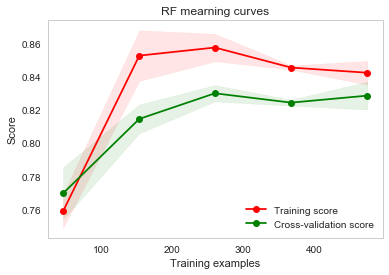

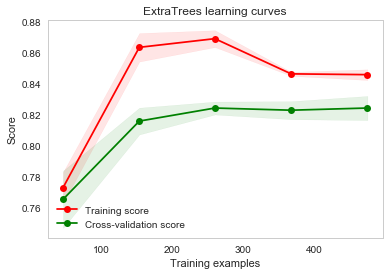

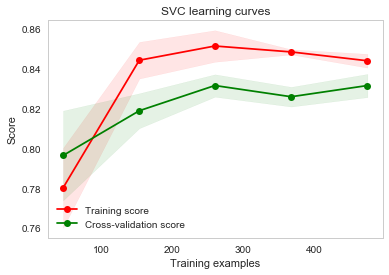

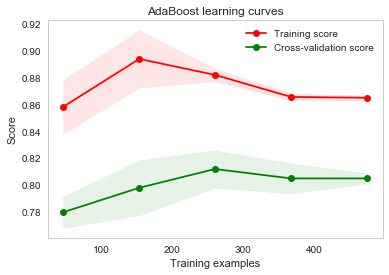

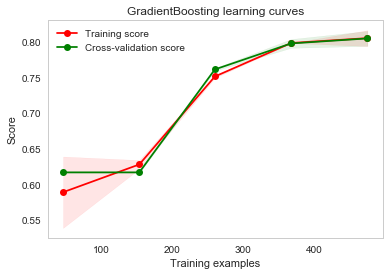

In [215]:
g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,y_train,cv=kfold)

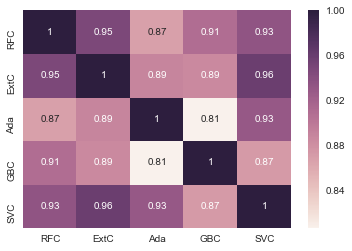

In [216]:
test_Survived_RFC = pd.Series(RFC_best.predict(X_test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(X_test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(X_test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(X_test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(X_test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)

# correlation map of different models
g= sns.heatmap(ensemble_results.corr(),annot=True)

In [266]:
# Using Voting ensemble learning model
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', weights=[3,1,2,2,4], n_jobs=-1)

votingC = votingC.fit(X_train, y_train)

In [267]:
votingC.score(X_test,y_test)

0.83240223463687146

In [268]:
conf_inter(ACC,n,z)

the condifedence interval is (0.7815105158948278,0.8721207690213734)


In [269]:
# Area under the curve
print(metrics.roc_auc_score(y_test,votingC.predict(X_test) ))

0.798814229249


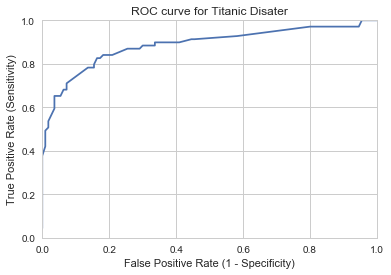

In [275]:
# Plot the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, votingC.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Titanic Disater')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [272]:
# Train the whole data on the Voting classifier
votingC.fit(X,y)

VotingClassifier(estimators=[('rfc', RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=6, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0,...=300, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))],
         n_jobs=-1, voting='soft', weights=[3, 1, 2, 2, 4])

In [273]:
# Make prediction then submission to Kaggle
test_Y = votingC.predict( test_submission )
passenger_id = full[len(train):].PassengerId
test = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': test_Y } )
test.shape
test.head()
test.to_csv( 'titanic_pred_ensem.csv' , float_format='%.f', index = False )

Public score on Kaggle was : 0.81818

In [274]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://i68.tinypic.com/14mdsvk.png")